# Preventing Customer Churn, Identifying Hidden Segments and Improving Satisfaction of Pharmaceutical Drug Users

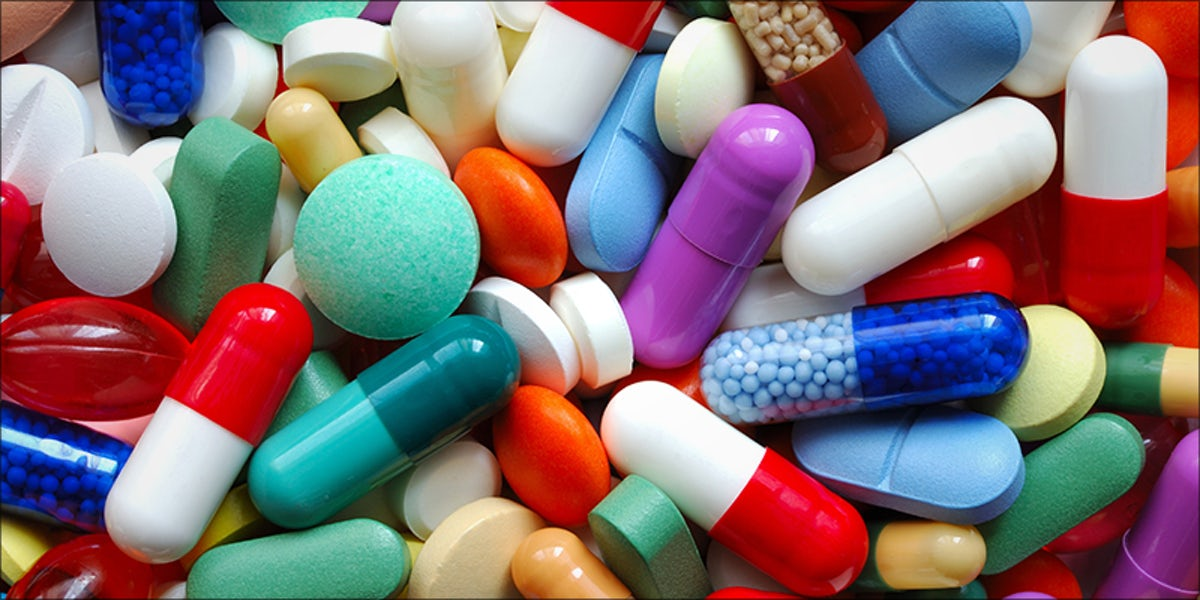

## Executive Summary
This notebook runs the classification models, the target variable is sentiment rate (1=positive sentiment, 0=negative sentiment). The models are Logistic Regression, Naive Bayes, Random Forest, XGBoost and Neural Network. The models were firstly ran on training set. The training set was an unbalanced one, there were many more positive reviews compared to negative reviews. We resolved the situation by oversample the negative reviews to create a balance training set. We choose to oversample because it prevents losing information. After which, the models were assessed based on accuracy, precision and recall. Logistic Regession and Random Forest were selected as the preferred models. These two models were then ran on testing set. Logistic Regression provides good explainability which helps in our recommendations while Random Forest gives good prediction accuracy.   

### Contents:
- [1. Importing the Libraries](#1.-Importing-the-Libraries)
- [2. Sentiment Analysis using TextBlob](#2.-Sentiment-Analysis-using-TextBlob)
- [3. Baseline Score](#3.-Baseline-Score)
- [4. Logistic-Regression](#4.-Logistic-Regression)
- [5. Navie Bayes](#5.-Navie-Bayes)
- [6. Random Forest](#6.-Random-Forest)
- [7. XGBoost](#7.-XGBoost)
- [8. Neural Network](#8.-Neural-Network)
- [9. Train Test Split Test Data](#9.-Train-Test-Split-Test-Data)
- [10. Running Test Data on Logistic Model](#10.-Running-Test-Data-on-Logistic-Model)
- [11. Running Test Data on Random Forest](#11.-Running-Test-Data-on-Random-Forest)

## 1. Importing the Libraries

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import r2_score,mean_squared_error,confusion_matrix,accuracy_score, classification_report
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
import xgboost as xgb

%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from textblob import TextBlob
import matplotlib.pyplot as plt
from PIL import Image

from datetime import datetime
from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances
import re
import os
import time
from sklearn.utils import resample

In [2]:
# Checking df_train_cleaned export properly
df_train_cleaned = pd.read_csv("../datasets/df_train_cleaned.csv")
df_train_cleaned.head()

,uniqueid,drugName,condition,review,rating,date,usefulCount,text length,sentiment_rate,month,year
0,206461,Valsartan,Left Ventricular Dysfunction,ha side effect take combination bystolic and f...,9.0,2012-05-20,27,79,1,5,2012
1,95260,Guanfacine,ADHD,son halfway through his fourth week intuniv be...,8.0,2010-04-27,192,741,1,4,2010
2,92703,Lybrel,Birth Control,used take another oral contraceptive which had...,5.0,2009-12-14,17,755,0,12,2009
3,138000,Ortho Evra,Birth Control,this first time using any form birth control g...,8.0,2015-11-03,10,448,1,11,2015
4,35696,Buprenorphine / naloxone,Opiate Dependence,suboxone ha completely turned life around feel...,9.0,2016-11-27,37,719,1,11,2016


In [3]:
# Checking df_train_cleaned export properly
df_test_cleaned = pd.read_csv("../datasets/df_test_cleaned.csv")
df_test_cleaned.head()

,uniqueid,drugName,condition,review,rating,date,usefulCount,text length,sentiment_rate,month,year
0,163740,Mirtazapine,Depression,tried few antidepressant over the year citalop...,10.0,2012-02-28,22,439,1,2,2012
1,206473,Mesalamine,"Crohn's Disease, Maintenance",son ha crohn disease and ha done very well the...,8.0,2009-05-17,17,268,1,5,2009
2,159672,Bactrim,Urinary Tract Infection,quick reduction symptom,9.0,2017-09-29,3,29,1,9,2017
3,39293,Contrave,Weight Loss,contrave combine drug that were used for alcoh...,9.0,2017-03-05,35,782,1,3,2017
4,97768,Cyclafem 1 / 35,Birth Control,have been this birth control for one cycle aft...,9.0,2015-10-22,4,762,1,10,2015


In [4]:
df_train_cleaned['review'].isnull().sum()

11

In [5]:
df_test_cleaned['review'].isnull().sum()

5

In [6]:
df_train_cleaned.dropna(inplace=True)
df_test_cleaned.dropna(inplace=True)

In [7]:
stops = set(stopwords.words('english'))

In [8]:
df_train_cleaned['review'].apply(lambda x: [word for word in x if word not in stops])

0         [h,  , e,  , e, f, f, e, c,  , k, e,  , c, b, ...
1         [n,  , h, l, f, w,  , h, r, u, g, h,  , h,  , ...
2         [u, e,  , k, e,  , n, h, e, r,  , r, l,  , c, ...
3         [h,  , f, r,  , e,  , u, n, g,  , n,  , f, r, ...
4         [u, b, x, n, e,  , h,  , c, p, l, e, e, l,  , ...
                                ...                        
160309    [w, r, e,  , f, r,  , r, e, p, r,  ,  , c, b, ...
160310    [w,  , g, v, e, n,  , h,  , b, e, f, r, e,  , ...
160311    [l, e,  , p, r, v, e, e, n,  , f, e, r,  , n, ...
160312    [b, e, e, n,  , h, r,  , e, c, n,  , e, r,  , ...
160313    [h,  , c, h, r, n, c,  , c, n, p, n,  , l, l, ...
Name: review, Length: 160303, dtype: object

In [9]:
df_train_cleaned.shape

(160303, 11)

In [10]:
df_test_cleaned.shape

(53466, 11)

## 2. Sentiment Analysis using TextBlob

In [11]:
def sentiment(review):
    # Sentiment polarity of the reviews
    pol = []
    for i in review:
        analysis = TextBlob(i)
        pol.append(analysis.sentiment.polarity)
    return pol

In [12]:
df_train_cleaned['sentiment'] = sentiment(df_train_cleaned['review'])

In [13]:
np.corrcoef(df_train_cleaned['sentiment'], df_train_cleaned['rating'])

array([[1.        , 0.34674697],
       [0.34674697, 1.        ]])

In [14]:
df_train_cleaned.head()

,uniqueid,drugName,condition,review,rating,date,usefulCount,text length,sentiment_rate,month,year,sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,ha side effect take combination bystolic and f...,9.0,2012-05-20,27,79,1,5,2012,0.000000
1,95260,Guanfacine,ADHD,son halfway through his fourth week intuniv be...,8.0,2010-04-27,192,741,1,4,2010,0.203596
2,92703,Lybrel,Birth Control,used take another oral contraceptive which had...,5.0,2009-12-14,17,755,0,12,2009,0.083663
3,138000,Ortho Evra,Birth Control,this first time using any form birth control g...,8.0,2015-11-03,10,448,1,11,2015,0.179545
4,35696,Buprenorphine / naloxone,Opiate Dependence,suboxone ha completely turned life around feel...,9.0,2016-11-27,37,719,1,11,2016,0.163333


### Comment
The sentiment analysis using textblob seems to be not that accurate. The coorelation between sentiment and rating are weak (0.35). The coorelation between sentiment and rating should be a strong one because rating was the original sentiment of users. Besides that, looking at the first 5 reviews, the orignal rating was high (8-9) but the sentiment score was near zero (meaning neutral sentiment). Therefore, we need to come up with models to more accurately classify positive and negative sentiments. 

In [15]:
X = df_train_cleaned['review']
y = df_train_cleaned['sentiment_rate']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101, stratify=y)

In [17]:
# The dataset seems to be unbalance.
y.value_counts(normalize=True)

1    0.702077
0    0.297923
Name: sentiment_rate, dtype: float64

In [18]:
# dealing with unbalance dataset, I will upsample the negative sentiment 
# concatenate our training data back together
df = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
# Separate majority and minority classes
df_majority = df[df.sentiment_rate==1]
df_minority = df[df.sentiment_rate==0]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=101) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 

In [19]:
X = df_upsampled['review']
y = df_upsampled['sentiment_rate']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101, stratify=y)

### Comment
The training dataset is unbalanced. There are far too many positive sentiment compared to negative sentiment. Our models may not be able to train accurately with such an unbalanced dataset. I have chosen to oversample the negative sentiment as I do not want to lose information by under sample postive sentiment. 

## 3. Baseline Score

In [21]:
y.value_counts(normalize=True)

1    0.5
0    0.5
Name: sentiment_rate, dtype: float64

### Comment
- If we were to pick every review belongs to positive sentiment, 50% of the time we will be correct. 

## 4. Logistic Regression

In [22]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])
params = {
    'tfidf__max_df': [.08, .85, 1],
    'tfidf__min_df': [2, 4],
    'tfidf__max_features': [3000, 4000],
    'lr__penalty':['l1','l2']
}
gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr__penalty': ['l1', 'l2'],
                         'tfidf__max_df': [0.08, 0.85, 1],
                         'tfidf__max_features': [3000, 4000],
                         'tfidf__min_df': [2, 4]})

In [23]:
# Grid Search reveal the best parameters
gs.best_params_

{'lr__penalty': 'l2',
 'tfidf__max_df': 0.85,
 'tfidf__max_features': 4000,
 'tfidf__min_df': 4}

In [24]:
gs.best_score_

0.8221333536240664

In [25]:
tfidf = TfidfVectorizer(analyzer = "word",
                     stop_words='english',
                     max_df=0.85,
                     min_df=4,
                     ngram_range=(1,2),
                     max_features=4000)

In [26]:
# Fit our tfidf-Vectorizer on the training data and transform training data.
X_train_tfidf = pd.DataFrame(tfidf.fit_transform(X_train).todense(),
                          columns = tfidf.get_feature_names())

In [27]:
# Transform our testing data with the already-fit tfidf-Vectorizer.
X_test_tfidf = pd.DataFrame(tfidf.transform(X_test).todense(),
                         columns = tfidf.get_feature_names())

In [28]:
lr = LogisticRegression(penalty='l2', C=1)

In [29]:
lr.fit(X_train_tfidf,y_train)

LogisticRegression(C=1)

In [30]:
y_pred = lr.predict(X_test_tfidf)

In [31]:
cross_val_score(lr, X_train_tfidf, y_train, cv=5).mean()

0.8184913134780342

In [32]:
print('mean accuracy on itself:', lr.score(X_train_tfidf, y_train))
print('mean accuracy on test set:', lr.score(X_test_tfidf, y_test))

mean accuracy on itself: 0.8360582727974506
mean accuracy on test set: 0.8217328403793602


In [33]:
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[20670  4214]
 [ 4658 20226]]


              precision    recall  f1-score   support

           0       0.82      0.83      0.82     24884
           1       0.83      0.81      0.82     24884

    accuracy                           0.82     49768
   macro avg       0.82      0.82      0.82     49768
weighted avg       0.82      0.82      0.82     49768



In [34]:
lr_coef_value = pd.DataFrame(data=lr.coef_.T, index=tfidf.get_feature_names())
lr_coef_value.columns = ['coef']
lr_coef_value['exp_coef'] = np.exp(lr_coef_value['coef'])
lr_coef_value.sort_values(by='exp_coef', ascending=False).head(10)

,coef,exp_coef
love,9.685240,16078.535871
amazing,8.946400,7680.194495
miracle,7.947073,2827.286526
saved,6.836992,931.682795
changed life,6.614966,746.179353
best,6.444387,629.161030
great,6.350713,572.900785
wonderful,6.019629,411.425725
highly recommend,5.321414,204.673162
complaint,5.068690,158.965967


In [35]:
lr_coef_value.sort_values(by='exp_coef').head(10)

,coef,exp_coef
worse,-7.135650,0.000796
disappointed,-6.493253,0.001514
worst,-5.383667,0.004591
stay away,-4.674957,0.009326
useless,-4.665080,0.009418
stopped taking,-4.628729,0.009767
ruined,-4.598670,0.010065
wouldn recommend,-4.545764,0.010612
horrible,-4.292325,0.013673
wa excited,-4.185803,0.015210


### Comment
- The model has a high mean accuracy score (0.8360582727974506 for training data) and (0.8217328403793602 for validation data)
- There seems to be minimal overfitting as as the mean accuracy scores are similar for both training and validation. 
- The model also has a high recall (i.e the percent of positive cases I catch) of 0.81 for positive sentiment.
- It also has a high precision (i.e the percent of my predictions were correct) score of 0.83 for positive sentiment.
- From the logistic model, the presence of words such as 'love', 'amazing', 'miracle' increases by 1, the review is about 16078, 7680, 2827 times respectively as likely to be a positive review. 
- On the other hand, the presence of words such as 'worse', 'disappointed', 'worst' increases by 1, the review is about 0.000796, 0.001514, 0.004591 times respectivley as likely to be a positive review (meaning more likely to be a negative review).

## 5. Navie Bayes

In [36]:
# Start our timer.
t0 = time.time()

tfidf = TfidfVectorizer(analyzer = "word",
                     stop_words='english',
                     max_df=0.85,
                     min_df=4,
                     ngram_range=(1,2),
                     max_features=4000)

# Stop our timer and print the result.
print(time.time()-t0)

0.5577480792999268


In [37]:
X_train_tfidf = pd.DataFrame(tfidf.fit_transform(X_train).todense(),
                          columns = tfidf.get_feature_names())

In [38]:
X_test_tfidf = pd.DataFrame(tfidf.transform(X_test).todense(),
                         columns = tfidf.get_feature_names())

In [39]:
nb = MultinomialNB()

In [40]:
nb.fit(X_train_tfidf,y_train)

MultinomialNB()

In [41]:
y_pred = nb.predict(X_test_tfidf)

In [42]:
t0 = time.time()
cross_val_score(nb, X_train_tfidf, y_train, cv=5).mean()
print(time.time()-t0)

88.99596405029297


In [43]:
print('model accuracy on itself:', nb.score(X_train_tfidf, y_train))
print('model accuracy on test set:', nb.score(X_test_tfidf, y_test))

model accuracy on itself: 0.7830605094911027
model accuracy on test set: 0.7764025076354284


In [44]:
print(confusion_matrix(y_test, y_pred))

[[19198  5686]
 [ 5442 19442]]


In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.77      0.78     24884
           1       0.77      0.78      0.78     24884

    accuracy                           0.78     49768
   macro avg       0.78      0.78      0.78     49768
weighted avg       0.78      0.78      0.78     49768



### Comment
- The model has a high mean accuracy score (0.7830605094911027 for training data) and (0.7764025076354284 for validation data)
- There seems to be minimal overfitting as as the mean accuracy scores are similar for both training and validation. 
- The model also has a high recall (i.e the percent of positive cases I catch) of 0.78 for positive sentiment.
- It also has a high precision (i.e the percent of my predictions were correct) score of 0.77 for positive sentiment.

## 6. Random Forest

In [46]:
# Start our timer.
t0 = time.time()

tfidf = TfidfVectorizer(analyzer = "word",
                     stop_words='english',
                     max_df=0.85,
                     min_df=4,
                     ngram_range=(1,2),
                     max_features=4000)

# Stop our timer and print the result.
print(time.time()-t0)

0.5096681118011475


In [47]:
X_train_tfidf = pd.DataFrame(tfidf.fit_transform(X_train).todense(),
                          columns = tfidf.get_feature_names())

In [48]:
X_test_tfidf = pd.DataFrame(tfidf.transform(X_test).todense(),
                         columns = tfidf.get_feature_names())

In [49]:
rf = RandomForestClassifier(random_state = 42)

In [50]:
rf.fit(X_train_tfidf,y_train)

RandomForestClassifier(random_state=42)

In [51]:
y_pred = rf.predict(X_test_tfidf)

In [52]:
t0 = time.time()
cross_val_score(rf, X_train_tfidf, y_train, cv=5).mean()
print(time.time()-t0)

2490.6249029636383


In [53]:
print('model accuracy on itself:', rf.score(X_train_tfidf, y_train))
print('model accuracy on test set:', rf.score(X_test_tfidf, y_test))

model accuracy on itself: 0.9994952593970824
model accuracy on test set: 0.9308792798585437


In [54]:
print(confusion_matrix(y_test, y_pred))

[[23459  1425]
 [ 2015 22869]]


In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     24884
           1       0.94      0.92      0.93     24884

    accuracy                           0.93     49768
   macro avg       0.93      0.93      0.93     49768
weighted avg       0.93      0.93      0.93     49768



### Comment
- The model has a high mean accuracy score (0.9994952593970824 for training data) and (0.9308792798585437) for validation data.
- There seems to be overfitting as as the mean accuracy score for training is higher than validation mean accuracy score.
- The model also has a high recall (i.e the percent of positive cases I catch) of 0.92 for positive sentiment.
- It also has a high precision (i.e the percent of my predictions were correct) score of 0.94 for positive sentiment.
- Random Forest has the higest mean accuracy, recall and precision compared to all other models. 

## 7. XGBoost

In [56]:
import graphviz

In [57]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", 
                              n_estimators=20, 
                              random_state=42, 
                              eval_metric=["auc", "error", "error@0.6"])

In [58]:
xgb_model.fit(X_train_tfidf, y_train, early_stopping_rounds=10, eval_set=[(X_test_tfidf, y_test)], verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              eval_metric=['auc', 'error', 'error@0.6'], gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [59]:
y_pred = xgb_model.predict(X_test_tfidf)

In [60]:
accuracy_score(y_test, y_pred)

0.7420229866580935

In [61]:
print("best score: {0}, best iteration: {1}, best ntree limit {2}".format(xgb_model.best_score, 
                                                                          xgb_model.best_iteration, 
                                                                          xgb_model.best_ntree_limit))

best score: 0.291352, best iteration: 19, best ntree limit 20


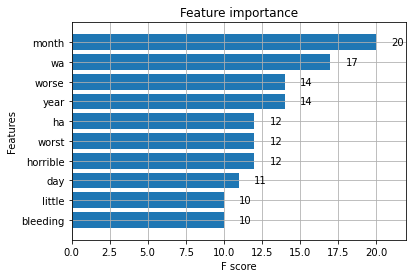

In [62]:
xgb.plot_importance(xgb_model, 
                   max_num_features=10,
                   height=0.8)

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75     24884
           1       0.76      0.70      0.73     24884

    accuracy                           0.74     49768
   macro avg       0.74      0.74      0.74     49768
weighted avg       0.74      0.74      0.74     49768



### Comment
- The model has a high accuracy score (0.9994506671135815 for training data) and (0.77) for validation data.
- There seems to be overfitting as as the mean accuracy score for training is higher than validation mean accuracy score.
- The model also has a high recall (i.e the percent of positive cases I catch) of 0.70 for positive sentiment.
- It also has a high precision (i.e the percent of my predictions were correct) score of 0.76 for positive sentiment.

## 8. Neural Network

In [64]:
import numpy as np
from sklearn.datasets import make_classification, make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

In [112]:
# Start our timer.
t0 = time.time()

tfidf = TfidfVectorizer(analyzer = "word",
                     stop_words='english',
                     max_df=0.85,
                     min_df=4,
                     ngram_range=(1,2),
                     max_features=4000)

# Stop our timer and print the result.
print(time.time()-t0)

0.08553171157836914


In [113]:
X_train_tfidf = pd.DataFrame(tfidf.fit_transform(X_train).todense(),
                          columns = tfidf.get_feature_names())

In [114]:
# Transform our testing data with the already-fit CountVectorizer.
X_test_tfidf = pd.DataFrame(tfidf.transform(X_test).todense(),
                         columns = tfidf.get_feature_names())

In [115]:
X_train_tfidf.shape

(101042, 4000)

In [116]:
model = Sequential()
model.add(Dense(32,
                input_shape=(4000,),
                activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [117]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                128032    
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 3         
Total params: 128,745
Trainable params: 128,745
Non-trainable params: 0
________________________________________________

In [118]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [119]:
history = model.fit(X_train_tfidf, y_train, validation_data=(X_test_tfidf, y_test), epochs=5, batch_size=32, verbose=0)

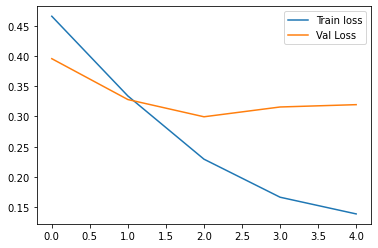

In [120]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend();

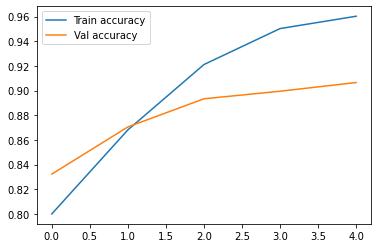

In [121]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend();

In [122]:
pred = model.predict_classes(X_test_tfidf)

In [123]:
from sklearn.metrics import classification_report

In [124]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     24884
           1       0.93      0.88      0.90     24884

    accuracy                           0.91     49768
   macro avg       0.91      0.91      0.91     49768
weighted avg       0.91      0.91      0.91     49768



### Comment
- The model has a high accuracy score of 0.91.
- The model also has a high recall (i.e the percent of positive cases I catch) of 0.88 for positive sentiment.
- It also has a high precision (i.e the percent of my predictions were correct) score of 0.93 for positive sentiment.
- Neural Network provide the second highest accuracy, recall and precision score. 

## 9. Train Test Split Test Data

In [127]:
# Preparing test data
X_train = df_train_cleaned['review']
y_train = df_train_cleaned['sentiment_rate']
X_test = df_test_cleaned['review']
y_test = df_test_cleaned['sentiment_rate']

## 10. Running Test Data on Logistic Model 

In [128]:
tfidf = TfidfVectorizer(analyzer = "word",
                     stop_words='english',
                     max_df=0.85,
                     min_df=4,
                     ngram_range=(1,2),
                     max_features=4000)

In [129]:
# Fit our tfidf-Vectorizer on the training data and transform training data.
X_train_tfidf = pd.DataFrame(tfidf.fit_transform(X_train).todense(),
                          columns = tfidf.get_feature_names())

In [130]:
# Transform our testing data with the already-fit tfidf-Vectorizer.
X_test_tfidf = pd.DataFrame(tfidf.transform(X_test).todense(),
                         columns = tfidf.get_feature_names())

In [131]:
lr = LogisticRegression(penalty='l2', C=1)

In [132]:
lr.fit(X_train_tfidf,y_train)

/Users/ytz/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1)

In [133]:
y_pred = lr.predict(X_test_tfidf)

In [134]:
cross_val_score(lr, X_train_tfidf, y_train, cv=5).mean()

/Users/ytz/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ytz/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

0.8359793485138075

In [135]:
print('mean accuracy on itself:', lr.score(X_train_tfidf, y_train))
print('mean accuracy on test set:', lr.score(X_test_tfidf, y_test))

mean accuracy on itself: 0.8473952452542997
mean accuracy on test set: 0.8359331163730221


In [136]:
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[10417  5702]
 [ 3070 34277]]


              precision    recall  f1-score   support

           0       0.77      0.65      0.70     16119
           1       0.86      0.92      0.89     37347

    accuracy                           0.84     53466
   macro avg       0.81      0.78      0.80     53466
weighted avg       0.83      0.84      0.83     53466



In [137]:
lr_coef_value = pd.DataFrame(data=lr.coef_.T, index=tfidf.get_feature_names())
lr_coef_value.columns = ['coef']
lr_coef_value['exp_coef'] = np.exp(lr_coef_value['coef'])
lr_coef_value.sort_values(by='exp_coef', ascending=False).head(10)

,coef,exp_coef
love,9.820405,18405.503769
amazing,8.745989,6285.427037
miracle,8.149585,3461.940519
changed life,7.387071,1614.969654
saved,7.004149,1101.192062
great,6.812076,908.755686
best,6.754044,857.519433
wonderful,6.144873,466.320538
complaint,5.749842,314.141105
highly recommend,5.564138,260.900160


In [138]:
lr_coef_value.sort_values(by='exp_coef').head(10)

,coef,exp_coef
worse,-6.596473,0.001365
disappointed,-6.450838,0.001579
wouldn recommend,-6.093831,0.002257
don recommend,-5.575770,0.003789
ruined,-5.477704,0.004179
worst,-5.471094,0.004207
doesn work,-4.861253,0.007741
stay away,-4.844076,0.007875
stopped taking,-4.693362,0.009156
waste,-4.577534,0.010280


### Comment
- The model has a high mean accuracy score (0.8473952452542997 for training data) and (0.8359331163730221 for validation data)
- There seems to be minimal overfitting as as the mean accuracy scores are similar for both training and testing. 
- The model also has a high recall (i.e the percent of positive cases I catch) of 0.92 for positive sentiment.
- It also has a high precision (i.e the percent of my predictions were correct) score of 0.86 for positive sentiment.
- From the logistic model, the presence of words such as 'love', 'amazing', 'miracle' increases by 1, the review is about 18405, 6285, 3461 times respectively as likely to be a positive review. 
- On the other hand, the presence of words such as 'worse', 'disappointed', 'wouldn recommend' increases by 1, the review is about 0.001365, 0.001579, 0.002257 times respectivley as likely to be a positive review (meaning more likely to be a negative review).

## 11. Running Test Data on Random Forest

In [139]:
# Start our timer.
t0 = time.time()

tfidf = TfidfVectorizer(analyzer = "word",
                     stop_words='english',
                     max_df=0.85,
                     min_df=4,
                     ngram_range=(1,2),
                     max_features=4000)

# Stop our timer and print the result.
print(time.time()-t0)

0.4608931541442871


In [140]:
rf = RandomForestClassifier(random_state = 42)

In [141]:
rf.fit(X_train_tfidf,y_train)

RandomForestClassifier(random_state=42)

In [142]:
y_pred = rf.predict(X_test_tfidf)

In [143]:
t0 = time.time()
cross_val_score(rf, X_train_tfidf, y_train, cv=5).mean()
print(time.time()-t0)

5216.737240076065


In [144]:
print('model accuracy on itself:', rf.score(X_train_tfidf, y_train))
print('model accuracy on test set:', rf.score(X_test_tfidf, y_test))

model accuracy on itself: 0.9994260868480316
model accuracy on test set: 0.914001421464108


In [145]:
print(confusion_matrix(y_test, y_pred))

[[12346  3773]
 [  825 36522]]


In [146]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.77      0.84     16119
           1       0.91      0.98      0.94     37347

    accuracy                           0.91     53466
   macro avg       0.92      0.87      0.89     53466
weighted avg       0.92      0.91      0.91     53466



### Comment
- The model has a high mean accuracy score (0.9994260868480316 for training data) and (0.914001421464108) for testing data.
- There seems to be overfitting as as the mean accuracy score for training is higher than validation mean accuracy score.
- The model also has a high recall (i.e the percent of positive cases I catch) of 0.98 for positive sentiment.
- It also has a high precision (i.e the percent of my predictions were correct) score of 0.91 for positive sentiment.
- This model gives a very good prediction accuracy.